/Users/kimdozz0/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


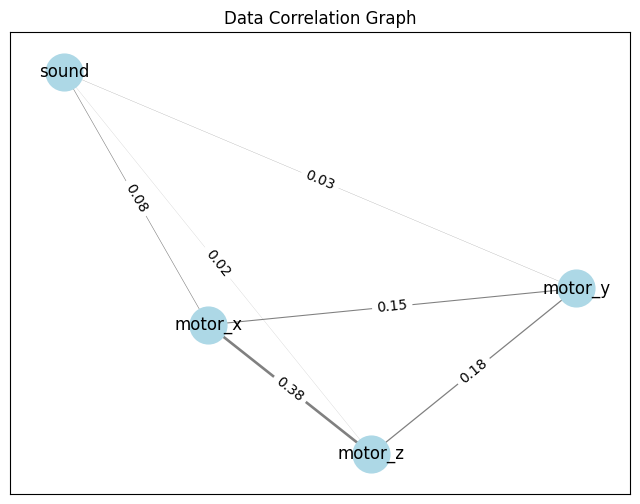

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# 파일 경로 설정
normal_file_path = './csv/5000hz/300rpm/300rpm normal data/stream2024_4_22_23_23.csv'

# CSV 파일 읽기
normal_df = pd.read_csv(normal_file_path)

# 상관 행렬 계산
corr_matrix = normal_df[['motor1_x', 'motor1_y', 'motor1_z', 'sound']].corr().values

# 상관계수 임계값 설정
threshold = 0  # 임계값을 0으로 설정하여 모든 관계 포함
edges = np.where(np.abs(corr_matrix) > threshold)

# 노드 이름 설정
node_labels = ['motor_x', 'motor_y', 'motor_z', 'sound']

# 그래프 생성
G = nx.Graph()

# 노드 추가
for node in node_labels:
    G.add_node(node)

# 엣지 추가
for i in range(len(edges[0])):
    if edges[0][i] != edges[1][i]:  # 자기 자신과의 엣지 제외
        G.add_edge(node_labels[edges[0][i]], node_labels[edges[1][i]], weight=np.abs(corr_matrix[edges[0][i], edges[1][i]]))

# 그래프 시각화
pos = nx.spring_layout(G, seed=42)  # 노드 배치 설정
plt.figure(figsize=(8, 6))

# 노드 그리기
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
# 엣지 그리기 (엣지 두께는 상관계수 크기에 비례)
edges = nx.draw_networkx_edges(G, pos, edge_color='gray', width=[G[u][v]['weight']*5 for u,v in G.edges()])
# 라벨 그리기
nx.draw_networkx_labels(G, pos, font_size=12, font_family="sans-serif")
# 엣지 라벨 그리기 (상관계수)
edge_labels = nx.get_edge_attributes(G, 'weight')
edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title("Data Correlation Graph")
plt.show()

/Users/kimdozz0/Library/Python/3.9/lib/python/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Epoch 1, Loss: 3.0843
Epoch 2, Loss: 23.1508
Epoch 3, Loss: 20.4646
Epoch 4, Loss: 19.1911
Epoch 5, Loss: 18.6665
Epoch 6, Loss: 18.4323
Epoch 7, Loss: 18.3791
Epoch 8, Loss: 18.2146
Epoch 9, Loss: 18.3433
Epoch 10, Loss: 18.4158
Epoch 11, Loss: 18.4732
Epoch 12, Loss: 18.5103
Epoch 13, Loss: 18.4033
Epoch 14, Loss: 18.3839
Epoch 15, Loss: 18.1593
Epoch 16, Loss: 17.9604
Epoch 17, Loss: 17.7840
Epoch 18, Loss: 17.5731
Epoch 19, Loss: 17.4510
Epoch 20, Loss: 17.2457
Epoch 21, Loss: 17.0717
Epoch 22, Loss: 16.9660
Epoch 23, Loss: 16.6863
Epoch 24, Loss: 16.6218
Epoch 25, Loss: 16.4987
Epoch 26, Loss: 16.3204
Epoch 27, Loss: 15.8646
Epoch 28, Loss: 15.5327
Epoch 29, Loss: 15.2640
Epoch 30, Loss: 15.0847
Epoch 31, Loss: 14.9688
Epoch 32, Loss: 14.8132
Epoch 33, Loss: 14.7262
Epoch 34, Loss: 14.6696
Epoch 35, Loss: 14.6903
Epoch 36, Loss: 14.7174
Epoch 37, Loss: 14.8815
Epoch 38, Loss: 14.9203
Epoch 39, Loss: 14.7806
Epoch 40, Loss: 14.7157
Epoch 41, Loss: 14.7378
Epoch 42, Loss: 15.2112
Ep

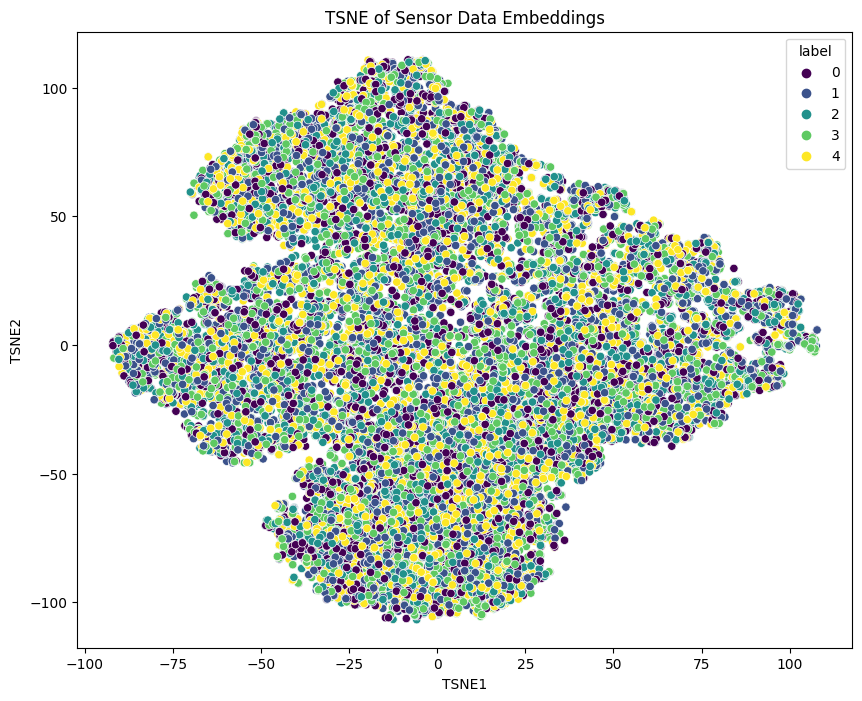

In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, VGAE
from torch_geometric.data import Data
from torch_geometric.utils import train_test_split_edges
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pywt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

# 데이터 파일 로드 및 정규화
def normalize_data(df):
    scaler = StandardScaler()
    return scaler.fit_transform(df)

def load_and_normalize_data(filenames, label):
    data_list = []
    for filename in filenames:
        df = pd.read_csv(filename)
        motor_data_normalized = normalize_data(df[['motor1_x', 'motor1_y', 'motor1_z']])
        sound_data_normalized = normalize_data(df[['sound']])
        data_list.append((motor_data_normalized, sound_data_normalized, label))
    return data_list

normal_files = ["./csv/5000hz/300rpm/300rpm normal data/stream2024_4_22_23_22.csv"]
fault1_files = ["./csv/5000hz/300rpm/300rpm carriage damage/stream2024_4_23_2_56.csv"]
fault2_files = ["./csv/5000hz/300rpm/300rpm high-speed damage/stream2024_4_23_0_20.csv"]
fault3_files = ["./csv/5000hz/300rpm/300rpm lack of lubrication/stream2024_4_23_2_6.csv"]
fault4_files = ["./csv/5000hz/300rpm/300rpm oxidation and corrosion/stream2024_4_23_1_15.csv"]

data_normal = load_and_normalize_data(normal_files, 0)
data_fault1 = load_and_normalize_data(fault1_files, 1)
data_fault2 = load_and_normalize_data(fault2_files, 2)
data_fault3 = load_and_normalize_data(fault3_files, 3)
data_fault4 = load_and_normalize_data(fault4_files, 4)

all_data = data_normal + data_fault1 + data_fault2 + data_fault3 + data_fault4

# 시계열 데이터를 윈도우로 분할
def create_windows(data, window_size, stride):
    windows = []
    labels = []
    for (motor_data, sound_data, label) in data:
        combined_data = np.hstack([motor_data, sound_data])
        for i in range(0, len(combined_data) - window_size + 1, stride):
            window = combined_data[i:i + window_size, :]
            windows.append(window)
            labels.append(label)
    return np.array(windows), np.array(labels)

window_size = 100
stride = 50
features, labels = create_windows(all_data, window_size, stride)

# CWT 변환 함수
def apply_cwt(windows, scales, waveletname='morl'):
    cwt_windows = []
    for window in windows:
        cwt_result = []
        for signal in window.T:
            coeff, _ = pywt.cwt(signal, scales, waveletname)
            cwt_result.append(np.abs(coeff))
        cwt_windows.append(np.array(cwt_result))
    return np.array(cwt_windows)

# CWT 변환 적용
scales = np.arange(1, 51)  # 스케일 범위 설정
cwt_features = apply_cwt(features, scales)

# CWT 결과를 (samples, time, features) 형태로 변환
cwt_features = cwt_features.transpose(0, 2, 1, 3)  # (samples, time, features)

# 노드 특성 정규화
scaler = StandardScaler()
features_scaled = scaler.fit_transform(cwt_features.reshape(cwt_features.shape[0], -1))

# KNN을 사용하여 엣지 생성
k = 5
knn = NearestNeighbors(n_neighbors=k).fit(features_scaled)
distances, indices = knn.kneighbors(features_scaled)

edge_index = []
for i in range(indices.shape[0]):
    for j in range(1, k):
        edge_index.append([i, indices[i, j]])

edge_index = np.array(edge_index).T

# 그래프 데이터 객체 생성
x = torch.tensor(features_scaled, dtype=torch.float)
edge_index = torch.tensor(edge_index, dtype=torch.long)
data = Data(x=x, edge_index=edge_index)

# 그래프 데이터 분할
data = train_test_split_edges(data)

# GraphVAE 모델 정의
class GraphVAE(VGAE):
    def __init__(self, in_channels, out_channels):
        encoder = torch.nn.ModuleList([
            GCNConv(in_channels, 16),
            GCNConv(16, out_channels)
        ])
        super(GraphVAE, self).__init__(encoder)
        self.conv1 = encoder[0]
        self.conv2 = encoder[1]
        self.__mu__ = None
        self.__logstd__ = None

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        self.__mu__ = self.conv2(x, edge_index)
        self.__logstd__ = torch.zeros_like(self.__mu__)
        return self.__mu__

# 모델 학습
in_channels = x.shape[1]
out_channels = 16  # 잠재 공간의 차원 수를 늘립니다.
model = GraphVAE(in_channels, out_channels)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    loss = model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

# 학습된 모델을 사용하여 노드 임베딩 추출
model.eval()
with torch.no_grad():
    z = model.encode(data.x, data.test_pos_edge_index)

# 임베딩과 레이블 준비
X = z.cpu().numpy()
y = labels

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# ConvLSTM 모델 정의
class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        super(ConvLSTMCell, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.bias = bias
        
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state
        
        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis
        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        
        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, num_classes, bias=True):
        super(ConvLSTM, self).__init__()

        self.conv_lstm_cell = ConvLSTMCell(input_dim, hidden_dim, kernel_size, bias)
        self.fc = nn.Linear(hidden_dim * input_dim, num_classes)  # hidden_dim * input_dim 크기 변경
    
    def forward(self, x):
        batch_size, seq_len, height, width = x.size()
        h, c = self.conv_lstm_cell.init_hidden(batch_size, (height, width))
        
        for t in range(seq_len):
            h, c = self.conv_lstm_cell(x[:, t, :, :].unsqueeze(1), (h, c))
        
        h = h.view(batch_size, -1)
        out = self.fc(h)
        
        return out

# 하이퍼파라미터 설정
input_dim = 1  # 입력 채널 수 (임베딩 차원을 채널로 사용)
hidden_dim = 64
kernel_size = 3
num_classes = len(np.unique(y))

# 모델 초기화
conv_lstm_model = ConvLSTM(input_dim, hidden_dim, kernel_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(conv_lstm_model.parameters(), lr=0.001)

# 데이터셋 및 데이터로더 생성
# 임베딩을 (batch_size, seq_len, height, width) 형태로 변환
X_train_reshaped = torch.tensor(X_train, dtype=torch.float32).unsqueeze(2).unsqueeze(3)
X_test_reshaped = torch.tensor(X_test, dtype=torch.float32).unsqueeze(2).unsqueeze(3)
train_dataset = TensorDataset(X_train_reshaped, torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(X_test_reshaped, torch.tensor(y_test, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델 학습
num_epochs = 100
conv_lstm_model.train()
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        outputs = conv_lstm_model(inputs)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')

# 모델 평가
conv_lstm_model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = conv_lstm_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# 성능 평가
print("Accuracy:", accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

# F1 스코어 계산
f1 = f1_score(y_true, y_pred, average='weighted')
print(f'F1 Score (weighted): {f1:.4f}')

# TSNE를 사용하여 임베딩 축소 및 시각화
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(X)  # z 대신 X를 사용하여 전체 데이터의 임베딩을 사용

# train_test_split에서 분할된 라벨 사용
df_embeddings = pd.DataFrame(embeddings_2d, columns=['TSNE1', 'TSNE2'])
df_embeddings['label'] = np.concatenate([y_train, y_test])  # 분할된 y_train과 y_test를 결합하여 사용

# TSNE 시각화
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_embeddings, x='TSNE1', y='TSNE2', hue='label', palette='viridis', legend='full')
plt.title("TSNE of Sensor Data Embeddings")
plt.show()
